# Machine Learning in Python - Project 1

Due Friday, March 11th by 5 pm.

*include contributors names here*

## 0. Setup

In [1]:
!pip install imblearn  

In [2]:
pip install schrutepy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#%%
#os library version
from pathlib import Path

# Data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


# extra modules
from schrutepy import schrutepy

##Global variables
##Threshold total line percentage for being a "main character"
P = 0.005



## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [5]:
##Load Data
d = pd.read_csv("../the_office.csv")
transcripts = schrutepy.load_schrute()



In [6]:
##copy original data so we don't lose it
df = d.copy()

##Note that some directors are repeated with different spellings. 
##Need to fix before any future data solutions
wrongdir_dict = {"Greg Daneils": "Greg Daniels", "Charles McDougal": "Charles McDougall",
                 "Claire Scanlong":"Claire Scanlon"}
df["director"].replace(wrongdir_dict, inplace=True)

In [7]:
##combining transcript data with original data to get character line information/important characters

##string cols
str_cols = (transcripts.applymap(type) == str).all(0)

##Lower names, character's and lines for easier processing
transcripts = transcripts.applymap(lambda s: s.lower() if type(s) == str else s)

##Remove spaces in character (some are incorrectly written like "jim ")
transcripts['character'] = transcripts['character'].str.replace(" ", "")
transcripts['season_ep'] = transcripts['season'].astype(str) + "_" + transcripts['episode'].astype(str)

# ##Per Episode Character lines
# transcripts.character.unique()
line_sum = transcripts.groupby(["season_ep", "character"]).size().reset_index(name = "lines") ##per character and episode lines
line_sum = line_sum.sort_values(ascending = False, by = "lines")##sort by lines

##Total line percentage per character
line_perc = line_sum.groupby("character").agg({"lines": "sum"}).sort_values(ascending = False, by = "lines")
line_perc['percentage'] = line_perc/(line_perc.sum())

##Greater than 1% line share
main_char = line_perc.loc[line_perc['percentage'] > P].index

##Top 10 line speakers (main_char)
# main_char = (line_perc.nlargest(10, 'percentage')).index

##per episode lines for main characters
line_main = line_sum.loc[line_sum['character'].isin(main_char)]

##Join main data with lines per character data

##convert line data into dataframe with each row as a season/episode and each column as the main character lines
char_lines = line_main.pivot_table(values='lines', index='season_ep', columns='character').reset_index()
char_lines = char_lines.fillna(0) ##fill NA values with zero because they are only not present if no lines were spoken

##calculate character line percentage per episode
perc_cols = char_lines.select_dtypes(include=np.number).columns + "_perc" ##create column names
char_lines[perc_cols] = char_lines.select_dtypes(include=np.number).div(d.n_lines, axis = 0) ##per row char line percentages

##Create character dummy variables for if present
main_char_dummy = [str(x) + "_dummy" for x in main_char]
char_lines[main_char_dummy] = (char_lines[main_char] > 0).astype(int)

##create season_ep column for d to join by
df['season_ep'] = df['season'].astype(str) + "_" + df['episode'].astype(str)

##join the main data with the lines per character data
df = pd.merge(df, char_lines, on = 'season_ep', how = 'left')


In [8]:
##Want to get a list of all writers and a list of all directors 
##Create new columns where the presence of each writer is it's own variable (one-hot encoding)

# convert string to lists
#df[["year", "month", "day"]] = pd.DataFrame(d.air_date.str.split("-").tolist()).astype(int)
df["writer"]                 = df["writer"].str.split(";")
df["main_chars"]             = df["main_chars"].str.split(";")
df["director"]               = df["director"].str.split(";")

##Now create dummy variables for each of the writers/directors (we are dropping main character dummies)

#######################################################################################################
##Functions to Modify Writer/Director##

##Function to split column with list variables into dummy variable columns
def split_col(column, df):
    ##For each episode, check which writiers or directosr are present and put into a dictionary
    ##Each column is a writer/direction; each row is an episode
    ##The value of row, column is T/F for whether a writer/director is present
    
    ##get all writers/directors in a flat list and then get unique writers/directors
    all_items = [item for ep_item in df[column] for item in ep_item] ##flattened list of writers/directors (duplicates)
    items = list(set(all_items)) ##gets list of unique writers/directors

    ##For each episode, check which writers/directors are present and put into a dictionary
    ##Each column is an individual writer/director; each row is an episode
    ##The value of row, column is T/F for whether a writer/director is present
    items_df = pd.DataFrame(list(map(lambda x: [i in x for i in items], df[column]))) ##this method worked on all computers
    items_df = items_df.astype(int) ##convert boolean T/F to 1/0
    items_df.columns = [str(x) + "_dummy" + "_" + column for x in items] ##item names + "dummy"
    
    return(items_df)


##Function to group "low" appearance directors/writers into one "low-appearance" column dummy variable
##Removes the original columns for those low-appearane writers directors
def categorize_low(column_type, df, threshold):
    ##if writer/director shows up less than or equal to the threshold, re-categorize to "Low-Appearance"
    items_eps = df.sum(axis = 0)
    low_appearance = list(items_eps[items_eps <= threshold].index) 
    new_col = "low_appearance" + "_" + column_type

    ##create new writer column for low-appearance
    df[new_col] = df[low_appearance].sum(axis = 1) > 0 ##Identifies episodes where a low_appearance writer/dir is
    df[new_col] = df[new_col].astype(int) ##convert boolean to integer
    
    ##drop original low_appearance columns
    df.drop(columns = low_appearance, inplace = True)
    
    return(df)

##End of Functions##
##################################################################################################################

##create dummy variable dataframes for writers and directors
writers_df = split_col(column = "writer", df = df)
directors_df = split_col(column = "director", df = df)

##group low-appearance writers and directors and remove columns for those low-appearance writers/directors
writers_df = categorize_low(column_type = "writer", df = writers_df, threshold = 2)
directors_df = categorize_low(column_type = "directors", df = directors_df, threshold = 2)

##Add the writer data to overall data
df = pd.concat([df, writers_df, directors_df], axis = 1)



In [9]:
##Create multipart episde columns

# Create column to indicate if said episode consist of multi parts
p = re.compile("Parts 1&2")
df["multi_part_dummy"] = [int(not int(pd.isnull(re.search(p,i)))) for i in df["episode_name"]]


In [10]:
##Replace any spaces in column names with "_"
df.columns = df.columns.str.replace(' ', '_')


In [11]:
##save data and filter to remove columns we don't want

##create data directory if it doesn't exist
if not os.path.exists("./data"): os.mkdir("./data")

# %%
df.to_csv("data/full_raw_dat.csv", index=False)

# remove unused columns and observations
col_drop = ["episode_name", "season_ep", "air_date", "episode", "writer", "director", "main_chars"]
p        = re.compile("Part [12]")
row_drop = [pd.isnull(re.search(p,i)) for i in df["episode_name"]]
fdat     = df.drop(col_drop,axis=1).iloc[row_drop,:]

Path("data").mkdir(parents=True, exist_ok=True)
fdat.to_csv("data/full_filtered_dat.csv", index=False)


**Standardizing and Splitting Data**

In [12]:
SEED = 55 ##for reproducibility

#%%
# read full data
fdat = pd.read_csv("data/full_filtered_dat.csv")

# separate response and explanatory data
X = fdat.drop("imdb_rating", axis=1)
y = fdat.imdb_rating

##Creating categorical version of response data for potential classifiers instead of regressors
cuts = [6,7,8,9,10] ##does not include the lowest; so here would make 4 bins between each of the numbers
binnames = ['4', '3', '2', '1'] ##name of bins with 1 being the best rating
y_class = pd.cut(y, cuts, labels = binnames)


# binlist = [y <= 7.5, y <= 8.5, y <= 9, y <= 10] ##cutoffs for different imdb categories
# binnames = ['1', '2', '3', "4"] ##names for the categories
# y_class = pd.Series(np.select(binlist, binnames, default='unknown')) 


# np.unique(y_class, return_counts=True)

# write raw files

##make new file
Path(f"./data/seed_{SEED}").mkdir(parents=True, exist_ok=True)

##split data into train test
##Numerical data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify = y_class)

##binned data (X_test and X_train are the same as above since we use the same seed, so no need to respecify)
##Unpack to _ and _ for both since we made above
_, _, y_train_cl, y_test_cl = train_test_split(X, y_class, test_size=0.33, random_state=SEED, stratify = y_class)



##Write to csvs for later

##numerical data
X_train.to_csv(f"data/SEED_{SEED}/X_train_raw.csv", index=False)
X_test.to_csv(f"data/SEED_{SEED}/X_test_raw.csv", index=False)
y_train.to_csv(f"data/SEED_{SEED}/y_train.csv", index=False)
y_test.to_csv(f"data/SEED_{SEED}/y_test.csv", index=False)

##binned data
y_train_cl.to_csv(f"data/SEED_{SEED}/y_train_cl.csv", index=False)
y_test_cl.to_csv(f"data/SEED_{SEED}/y_test_cl.csv", index=False)

# create pipeline for scalers
std_scale = Pipeline([('standard', StandardScaler())])
minmax_scale = Pipeline([('minmax', MinMaxScaler())])

# select columns that require scaling
##select dummy variables (All dummies are numeric, but binary)
##Therefore we select from numerics, but only if labeled with dummy writer or director

scale_col = X_train.select_dtypes(include = np.number) ##subset the numeric columns
cat_cols = scale_col.filter(regex = 'dummy|writer|director').columns ##subset the columns with dummy/writer/director

scale_col = [col for col in scale_col if col not in cat_cols] ##update scale_col with numeric columns not in dummy vars

# scale_col = X_train.iloc[:,0:24].select_dtypes(include=np.number).columns.tolist()


##Define column transformers for scaling and min/max transformations
minmax_prep = ColumnTransformer(
        remainder='passthrough', ##keep all columns not specified in transformer
        transformers=[
            ('minmax', minmax_scale , scale_col), ##apply minmax_scale to scale_col
        ])

std_prep = ColumnTransformer(
        remainder='passthrough', ##keep all columns not specified in transformer
        transformers=[
            ('std', std_scale , scale_col), ##apply std_scale to scale_col
        ])


#%%
# fit minmax on training data
minmax_prep.fit(X_train)
minmax_train = pd.DataFrame(minmax_prep.transform(X_train), columns = X_train.columns)
minmax_test = pd.DataFrame(minmax_prep.transform(X_test), columns = X_train.columns)##Transform test with fit from training

##fit scaler on training data
std_prep.fit(X_train)
std_train = pd.DataFrame(std_prep.transform(X_train), columns = X_train.columns)
std_test = pd.DataFrame(std_prep.transform(X_test), columns = X_train.columns) ##Transform test data with fit from training 


#%%

##write to csv
minmax_train.to_csv(f"data/SEED_{SEED}/X_train_minmax.csv", index=False)
minmax_test.to_csv(f"data/SEED_{SEED}/X_test_minmax.csv", index=False)
std_train.to_csv(f"data/SEED_{SEED}/X_train_std.csv", index=False)
std_test.to_csv(f"data/SEED_{SEED}/X_test_std.csv", index=False)

# %%


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

In [13]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge

In [14]:
X_train_std= pd.read_csv("data/seed_55/X_train_std.csv")
y_train_std = pd.read_csv("data/seed_55/y_train.csv")
X_test_std= pd.read_csv("data/seed_55/X_test_std.csv")
y_test_std = pd.read_csv("data/seed_55/y_test.csv")

In [40]:
ridge_model = Ridge(alpha=15.07537688442211).fit(X_train_std,y_train_std)

In [41]:
ridge_model.coef_

array([[ 2.14455394e-02,  2.07290439e-01,  3.32378176e-02,
        -1.40506020e-02, -2.08500345e-02, -4.53425636e-02,
        -3.04731555e-02, -7.75793497e-03,  2.14610345e-02,
         4.39323812e-02,  2.99028426e-02, -6.42864184e-03,
        -2.61506606e-02, -6.12483802e-03,  2.81830963e-02,
         2.41924060e-02,  7.18001547e-02, -1.84174729e-04,
        -1.04650196e-03,  9.07667042e-03,  3.01244039e-03,
         9.94329809e-03, -6.73465186e-02, -2.60015931e-02,
         2.13250569e-02,  2.01092454e-02, -5.15619165e-02,
         1.28097597e-02, -8.15559895e-03,  2.22027974e-02,
         2.18907761e-02,  5.96921324e-02, -2.65145922e-03,
         7.79508991e-03,  3.23106209e-02,  1.25296422e-02,
        -3.38673517e-04,  2.14393999e-02,  1.86693834e-03,
         3.33702419e-02,  1.63765578e-02, -2.14834745e-03,
         8.15839903e-03,  1.42899481e-02, -1.67711891e-02,
        -1.96830127e-02, -7.23132262e-02,  4.13111520e-02,
        -5.41268242e-02,  2.24091406e-02, -4.00575046e-0

In [42]:
y_hat = ridge_model.predict(X_test_std)


In [43]:
rmse = np.sqrt(mean_squared_error(y_test_std, y_hat))
rmse

0.43223655097136876

In [44]:
y_test_std.shape

(61, 1)

In [45]:
y_hat.shape

(61, 1)

In [46]:
resid = y_test_std - y_hat
resid

,imdb_rating
0,0.568774
1,-0.419683
2,-0.483648
3,-0.068321
4,0.114327
...,...
56,0.003019
57,0.609863
58,-0.370037
59,-0.094726


In [47]:
resid["y_test_std"]=y_test_std
resid["y_hat"]=y_hat

In [48]:
resid

,imdb_rating,y_test_std,y_hat
0,0.568774,8.7,8.131226
1,-0.419683,8.1,8.519683
2,-0.483648,8.0,8.483648
3,-0.068321,8.4,8.468321
4,0.114327,7.8,7.685673
...,...,...,...
56,0.003019,8.0,7.996981
57,0.609863,8.7,8.090137
58,-0.370037,7.7,8.070037
59,-0.094726,8.2,8.294726


In [54]:
from sklearn.metrics import r2_score
r2_score(y_test_std, y_hat)

0.36396284506887533

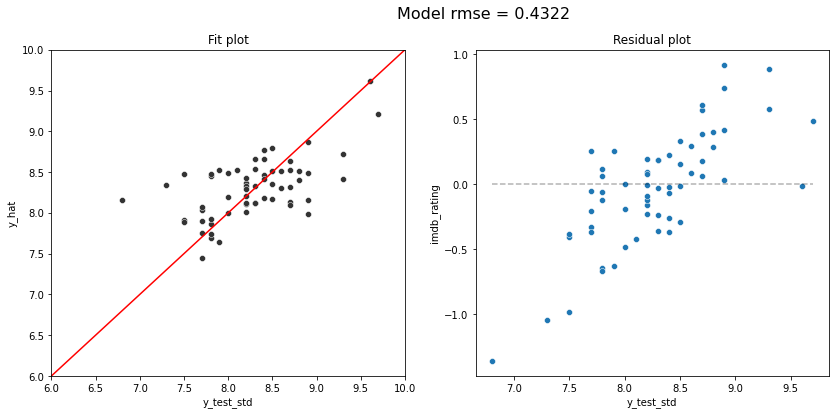

In [61]:
plt.figure(figsize=(12, 6))
        
plt.subplot(121)
plt.axline((1, 1), slope=1,color='r')
sns.scatterplot(x='y_test_std', y='y_hat', data=resid,color=".2").set_title("Fit plot")
plt.xlim([6, 10])   
plt.ylim([6, 10])   


plt.subplot(122)
sns.scatterplot(x='y_test_std', y='imdb_rating', data=resid).set_title("Residual plot")
plt.hlines(y=0, xmin=np.min(y_test_std), xmax=np.max(y_test_std), linestyles='dashed', alpha=0.3, colors="black")
        
plt.subplots_adjust(left=0.0)
    
plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
plt.show()
    

In [35]:
alphas = np.linspace(0, 60, num=200)


gs = GridSearchCV( make_pipeline(
        Ridge()),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train_std, y_train_std)

C:\Users\ANOUSHKA\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\ANOUSHKA\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\ANOUSHKA\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\ANOUSHKA\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\ANOUSHKA\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


In [39]:
print(gs.best_params_)

{'ridge__alpha': 15.07537688442211}


Pipeline(steps=[('ridge', Ridge(alpha=15.07537688442211))])


## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*